## 常见的数据增广
翻转：左右翻转、上下翻转 

切割：从原图中切割一块，然后变形到固定形状（随机高宽比、随机大小、随机位置）

颜色：改变色调、饱和度、明亮度

#### 数据增广通过变形数据获取多样性从而使得模型的泛化能力更好

In [5]:
%matplotlib inline
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

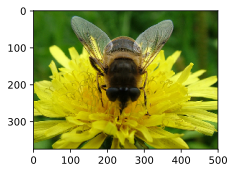

In [6]:
d2l.set_figsize()
img = Image.open('../img/bee1.jpg')
d2l.plt.imshow(img)

In [8]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    """对图片进行num_rows * num_cols次增广，并展示出来"""
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols)

AttributeError: detach

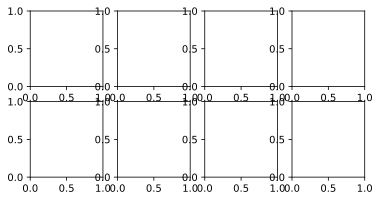

In [9]:
apply(img, torchvision.transforms.RandomVerticalFlip())

## 随机剪裁

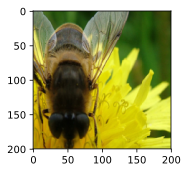

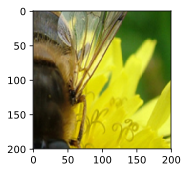

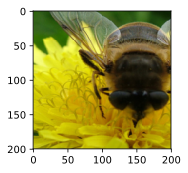

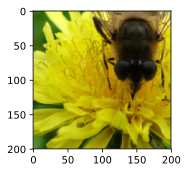

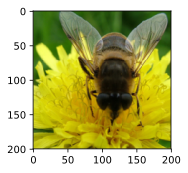

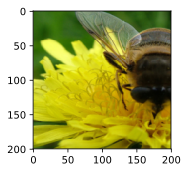

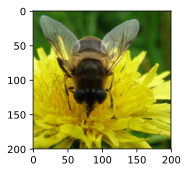

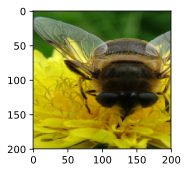

In [25]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), 
    scale=(0.1, 1), 
    ratio=(0.5, 2))
apply(img, shape_aug)

## 随机更改图像亮度、对比度、饱和度、色调

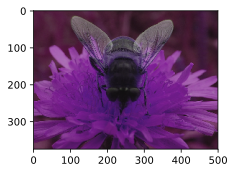

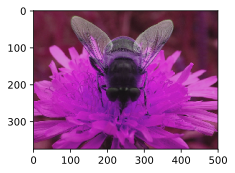

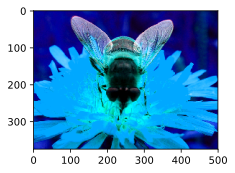

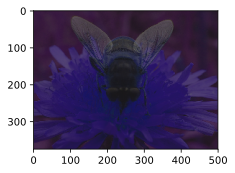

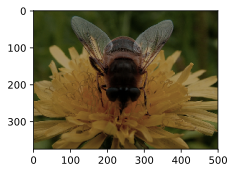

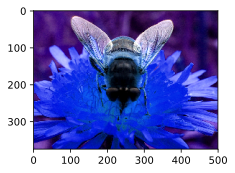

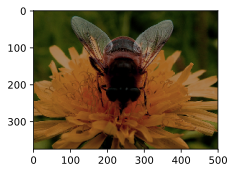

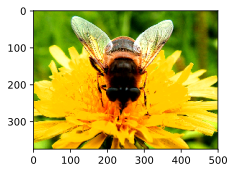

In [28]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5,
                                             contrast=0.5,
                                             saturation=0.5,
                                             hue=0.5)
apply(img, color_aug)

## 多种增广叠加使用（Compose）

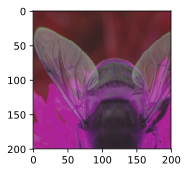

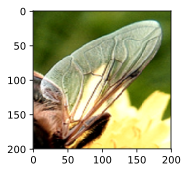

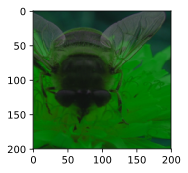

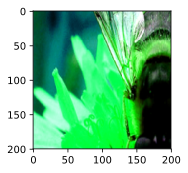

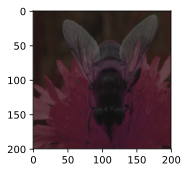

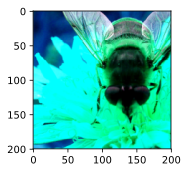

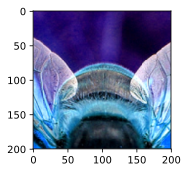

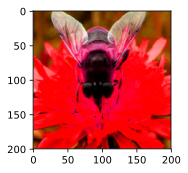

In [29]:
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),
                                      color_aug,
                                      shape_aug])
apply(img, augs)

## 使用图像增广进行模型训练

In [32]:
all_images = torchvision.datasets.CIFAR10(train=True,
                                         root='../data',
                                         download=False)
# 只使用最简单的随机左右翻转 
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
# 测试集只将图片转换成张量
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [33]:
def load_cifar10(is_train, augs, batch_size):
    """获取数据迭代器"""
    dataset = torchvision.datasets.CIFAR10(
        train=is_train, root='../data',
        transform=augs, download=True)
    
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        num_workers=4)
    
    return dataloader

In [46]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    # 数据移动到训练设备
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    # 开启训练模式
    net.train() 
    trainer.zero_grad() # 将参数的梯度清零
    y_hat = net(X) # 预测每个分类的概率
    l = loss(y_hat, y) # 计算损失
    l.sum().backward() # 计算梯度
    trainer.step() # 更新参数
    
    train_loss_sum = l.sum() # 损失之和
    train_acc_sum = d2l.accuracy(y_hat, y) # 预测正确的样本数
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
              devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 损失之和，预测正确样本数，样本总数,???
        metric = d2l.Accumulator(4)
        # ----------Train----------
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, 
                                      loss, trainer,devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            # 画图显示当前已训练样本的平均损失、精度
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))
        
        # ----------Valid----------
        # 计算当前模型在训练集的精度 
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 显示训练了num_epochs后的平均损失、精度、最终的测试精度
    print(f'loss {metric[0] / metric[2]:.3f}, train acc {metric[1] / metric[3]:.3f}, '
          f'test acc {test_acc:.3f}')
    
    # 显示每秒多少个样本
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices[0])}')

## 使用ResNet18进行训练
下面完整实现了一遍ResNet18的网络结构

In [36]:
batch_size, devices = 256, d2l.try_all_gpus()

class Residual(nn.Module):
    # 若输入通道与输出通道不同，需要使用1x1卷积修改通道数
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides) # 根据传入的strides可能会改变高宽
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1) # 不改变高宽
        if use_1x1conv:
            # 跨层数据通路
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
    
# CIFAR10的图片的RGB图片，通道数为3
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1)) 

def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = [] 
    for i in range(num_residuals):
        # 每个模块的第一个残差块使得通道翻倍，高宽减半
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) # 第二个模块不修改通道以及高宽
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [37]:
def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net,train_iter, test_iter, loss, trainer, 10, devices)

#### 数据增广能起到一定的正则化作用，减少过拟合

loss 0.153, train acc 0.947, test acc 0.719
2074.2 examples/sec on cuda:0


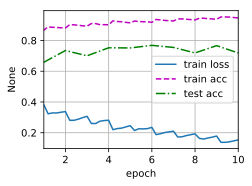

In [47]:
train_with_data_aug(train_augs, test_augs, net)